In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 42 kB/s 
     |████████████████████████████████| 199 kB 56.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845514 sha256=b664a46500de0f2f750cbed70b0b5c54257aa2a7d233c644deb5e2c0e58608af
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axis
import plotly.graph_objects as go

from pyspark.sql import SparkSession
spark  = SparkSession.builder.master("local").appName('ProjetSpark').getOrCreate()

from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Projet 2 : Accidents de la circulation en France

## Première partie : Nombre d'accidents suivant l'éclairage
**Objectif :**

On souhaite représenter graphiquement le nombre d’accident en fonction de la catégorie d’éclairage. 

On dispose de la colonne Num_Acc du jeu de données caracteristiques qui correspond au numéro de l'enregistrement de l'accident.

Par ailleurs, on distingue 5 conditions différentes d'éclairage suivant l'accident produit (donné par la variable lum du jeu de données caracteristiques également) : 
- Plein jour
- Crépuscule ou aube
- Nuit sans éclairage public
- Nuit avec éclairage public non allumé
- Nuit avec éclairage public allumé

### On parcourt l'ensemble des fichiers .csv année par année pour l'ensemble des rubriques

In [3]:
# Construction des 4 bases de données

years = range(2011, 2019) # listes des années

liste_caract = []
liste_lieux = []
liste_usagers = []
liste_vehicules = []

for year in years:
    caracteristiques = 'accidents/caracteristiques_{}.csv'.format(year)
    liste_caract.append(caracteristiques)

    lieux = 'accidents/lieux_{}.csv'.format(year)
    liste_lieux.append(lieux)

    usagers = 'accidents/usagers_{}.csv'.format(year)
    liste_usagers.append(usagers)

    vehicules = 'accidents/vehicules_{}.csv'.format(year)
    liste_vehicules.append(vehicules)

# Affichage des fichiers qui composent la base de données caracteristiques
print("listecaract", liste_caract)

listecaract ['accidents/caracteristiques_2011.csv', 'accidents/caracteristiques_2012.csv', 'accidents/caracteristiques_2013.csv', 'accidents/caracteristiques_2014.csv', 'accidents/caracteristiques_2015.csv', 'accidents/caracteristiques_2016.csv', 'accidents/caracteristiques_2017.csv', 'accidents/caracteristiques_2018.csv']


### Visualisation du jeu de données caractéristiques 

Nous allons seulement utiliser le jeu de données caracteristiques pour cette partie.

In [4]:
# Initialisation de la variable df1 : le premier .csv de caracteristiques (année 2011)
df1 = spark.read.load(liste_caract[0], format = 'csv', header=True) 

# On parcourt à compter de la deuxième année pour réaliser les jointures année par année
for dataframe in liste_caract:
    data_caract = spark.read.load(dataframe, format = 'csv', header=True)     # Chargement du fichier csv
    df1 = df1.unionByName(data_caract)                                        # Jointure sur les colonnes

# Affiche seulement les premières lignes de df1
df1.show()

# Vérification que la jointure 2018 fonctionne bien
#df1.tail(10)

+------------+---+----+----+----+---+---+---+---+---+---+--------------------+---+-------+-------+---+
|     Num_Acc| an|mois|jour|hrmn|lum|agg|int|atm|col|com|                 adr|gps|    lat|   long|dep|
+------------+---+----+----+----+---+---+---+---+---+---+--------------------+---+-------+-------+---+
|201100000001| 11|   1|  22|1400|  1|  2|  1|  1|  3|005|     RUE DE L'EGLISE|  M|5053589|0295262|590|
|201100000002| 11|   6|  24|1500|  1|  1|  1|  1|  3|011|       Rue de Carvin|  M|5051652|0293898|590|
|201100000003| 11|   9|  16| 645|  2|  2|  1|  1|  6|052|      rue de la gare|  M|5051080|0290322|590|
|201100000004| 11|   9|  22|1515|  1|  2|  1|  1|  5|011|     rue de Touraine|  M|5051861|0293043|590|
|201100000005| 11|  10|  24|1545|  1|  2|  1|  1|  6|011|    90 rue nationale|  M|5052506|0293541|590|
|201100000006| 11|  11|  14|1745|  5|  2|  1|  1|  2|011|       RUE NATIONALE|  M|5052684|0293423|590|
|201100000007| 11|   4|   8|1600|  1|  1|  1|  1|  3|320|                

In [5]:
# Nombre de lignes dans le dataframe
df1.count()
print(f"Le jeu de données caractéristiques contient {df1.count()} lignes.")

Le jeu de données caractéristiques contient 551019 lignes.


### Nombre d'accidents total

Un enregistrement correspond à un véhicule accidenté. On s'assure qu'il n'y a pas de doublons dans ce jeu de données.
C'est bien le cas car dans le jeu de données caractéristiques, un accident correspond à une ligne, on ne fait pas la distinction sur le véhicule touché (pas de colonne num_veh). Chaque ligne est bien unique.

In [ ]:
# Enlève les doublons dans la colonne Num_Acc du jeu de données caracteristiques
df1_sans_doublons = df1.select("Num_Acc")
df1_sans_doublons.distinct()                # enlève les doublons dans le nouveau dataframe (colonne Num_Acc)
df1_sans_doublons.show()                    
df1_sans_doublons.count()                   # compter le nombre de lignes : 551019 qui correspond au nombre d'accidents

In [7]:
print(f"Il y a {df1.count()} accidents enregistrés entre 2011 et 2018.")

Il y a 551019 accidents enregistrés entre 2011 et 2018.


### Transformation du jeu de données caracteristiques en DataFrame Pandas.

In [8]:
# Visualisation du jeu de données en Dataframe de Spark
df1.show()

+------------+---+----+----+----+---+---+---+---+---+---+--------------------+---+-------+-------+---+
|     Num_Acc| an|mois|jour|hrmn|lum|agg|int|atm|col|com|                 adr|gps|    lat|   long|dep|
+------------+---+----+----+----+---+---+---+---+---+---+--------------------+---+-------+-------+---+
|201100000001| 11|   1|  22|1400|  1|  2|  1|  1|  3|005|     RUE DE L'EGLISE|  M|5053589|0295262|590|
|201100000002| 11|   6|  24|1500|  1|  1|  1|  1|  3|011|       Rue de Carvin|  M|5051652|0293898|590|
|201100000003| 11|   9|  16| 645|  2|  2|  1|  1|  6|052|      rue de la gare|  M|5051080|0290322|590|
|201100000004| 11|   9|  22|1515|  1|  2|  1|  1|  5|011|     rue de Touraine|  M|5051861|0293043|590|
|201100000005| 11|  10|  24|1545|  1|  2|  1|  1|  6|011|    90 rue nationale|  M|5052506|0293541|590|
|201100000006| 11|  11|  14|1745|  5|  2|  1|  1|  2|011|       RUE NATIONALE|  M|5052684|0293423|590|
|201100000007| 11|   4|   8|1600|  1|  1|  1|  1|  3|320|                

In [9]:
# Affichage du Schéma du dataframe
df1.printSchema()

root
 |-- Num_Acc: string (nullable = true)
 |-- an: string (nullable = true)
 |-- mois: string (nullable = true)
 |-- jour: string (nullable = true)
 |-- hrmn: string (nullable = true)
 |-- lum: string (nullable = true)
 |-- agg: string (nullable = true)
 |-- int: string (nullable = true)
 |-- atm: string (nullable = true)
 |-- col: string (nullable = true)
 |-- com: string (nullable = true)
 |-- adr: string (nullable = true)
 |-- gps: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- dep: string (nullable = true)



In [10]:
type(df1)

pyspark.sql.dataframe.DataFrame

In [11]:
# Convertir Dataframe de Spark en Dataframe de Pandas
df_pandas = df1.toPandas()
print(df_pandas)

             Num_Acc  an mois jour  hrmn lum agg int atm col  com  \
0       201100000001  11    1   22  1400   1   2   1   1   3  005   
1       201100000002  11    6   24  1500   1   1   1   1   3  011   
2       201100000003  11    9   16   645   2   2   1   1   6  052   
3       201100000004  11    9   22  1515   1   2   1   1   5  011   
4       201100000005  11   10   24  1545   1   2   1   1   6  011   
...              ...  ..  ...  ...   ...  ..  ..  ..  ..  ..  ...   
551014  201800057779  18   12   15  1050   1   2   1   1   6  611   
551015  201800057780  18   12   16   610   2   2   1   1   3  611   
551016  201800057781  18   12   22  2150   5   2   1   1   6  611   
551017  201800057782  18   12   23  1945   5   2   1   1   1  611   
551018  201800057783  18   12   28  1425   1   2   1   1   1  611   

                             adr gps      lat     long  dep  
0                RUE DE L'EGLISE   M  5053589  0295262  590  
1                  Rue de Carvin   M  5051652  

In [12]:
type(df_pandas)

pandas.core.frame.DataFrame

### Nombre d'accidents pour les différents types d'éclairage

In [13]:
data = df_pandas.groupby('lum')['Num_Acc'].count()
data = data.reset_index()
data

,lum,Num_Acc
0,1,376779
1,2,33715
2,3,45326
3,4,4897
4,5,90302


### Représentation graphique : Histogramme (Nombre d'accidents en fonction de l'éclairage)

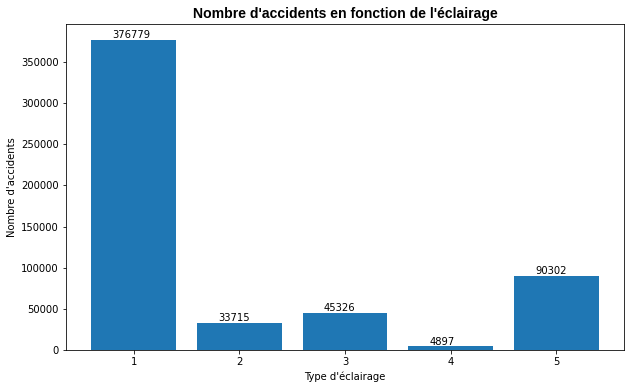

In [15]:
plt.figure(figsize=(10,6))

# Représentation de l'histogramme
plt.bar(data['lum'], data['Num_Acc'])

plt.title("Nombre d'accidents en fonction de l'éclairage", fontname ="Liberation Sans", fontsize=14, fontweight='bold')

# Ajouter les titres des axes avec xlabel et ylabel
plt.xlabel("Type d'éclairage")
plt.ylabel("Nombre d'accidents")

# Afficher valeurs textuelles des ordonnées
ac = data['Num_Acc'].tolist() # variable Num_Acc dans une liste
#print(ac)
for i in range(5):
  plt.text(i-0.2, ac[i]+2000, ac[i])

plt.show()

Sur ce graphique, on observe que la majorité des accidents ont lieu le jour.

### Autre représentation graphique : Diagramme circulaire (Pourcentage d'accidents en fonction de l'éclairage)

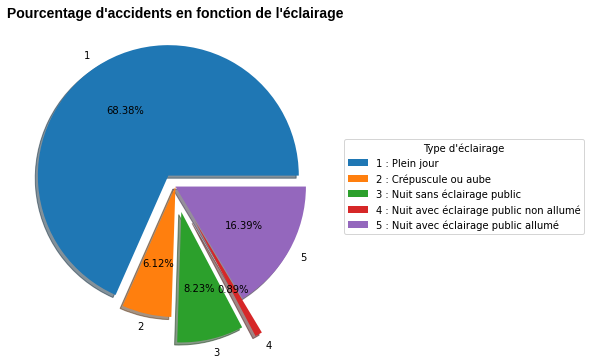

In [16]:
plt.figure(figsize=(10,6))
lumiere=['1 : Plein jour', '2 : Crépuscule ou aube', '3 : Nuit sans éclairage public', '4 : Nuit avec éclairage public non allumé', '5 : Nuit avec éclairage public allumé']

explode = (0.1, 0.0, 0.2, 0.3, 0.0)
plt.pie(x=data['Num_Acc'], labels=data['lum'], explode = explode, autopct='%.2f%%', shadow=True)

plt.title("Pourcentage d'accidents en fonction de l'éclairage", fontname ="Liberation Sans", fontsize=14, fontweight='bold')
plt.legend(lumiere, loc ="center left", bbox_to_anchor =(1, 0, 0.5, 1), title="Type d'éclairage")
plt.show()

Cet autre représentation graphique nous montre la proportion des accidents en fonction de l'éclairage. 

On constate que 68% des accidents se produisent en plein jour (part en bleu).

Par ailleurs, on remarque que seulement moins de 1% des accidents se produisent la nuit avec éclairage public non allumé contre 16% des accidents la nuit avec éclairage public allumé. Il semblerait que l'éclairage public allumé la nuit augmente les accidents, ce qui est une observation raisonnable.

Par ailleurs, la proportion des accidents la nuit sans éclairage public est de l'ordre de 8% contre 1% pour la nuit avec éclairage public non allumé. Il semblerait ici qu'il existe un autre facteur supplémentaire que le type d'éclairage qui favorise les accidents, on peut supposer que c'est la vitesse (vitesse supérieure à 50km/h hors agglomération).

### Agréger les données : sélection des colonnes utiles

In [17]:
# La fonction d'agrégation est la fonction count()
data1 = df_pandas.groupby(['lum', 'an'])['Num_Acc'].count() # grouper les variables
data2 = data1.reset_index()                                 # remplacer les index en colonnes
data2

,lum,an,Num_Acc
0,1,11,92538
1,1,12,42322
2,1,13,40098
3,1,14,41049
4,1,15,40598
5,1,16,40578
6,1,17,40895
7,1,18,38701
8,2,11,7726
9,2,12,3764


In [18]:
# Représentation de la colonne 'lum' en lignes et la colonne 'an' en colonnes
data3 = df_pandas.pivot_table(index='lum', columns='an', values='Num_Acc', aggfunc='count')
data3

an,11,12,13,14,15,16,17,18
lum,,,,,,,,
1,92538,42322,40098,41049,40598,40578,40895,38701
2,7726,3764,3564,3617,3479,3568,4158,3839
3,10416,4813,4467,4620,4746,5089,5601,5574
4,1114,619,565,548,454,508,514,575
5,22154,10732,9703,10020,9377,9689,9533,9094


### Histogramme par année

In [19]:
# Création de dataframes pour avoir la transposée du dataframes (data3)
d1 = data3.loc['1',:]
d2 = data3.loc['2',:]
d3 = data3.loc['3',:]
d4 = data3.loc['4',:]
d5 = data3.loc['5',:]

In [20]:
# Concaténer les dataframes
df_finalannees = pd.concat([d1, d2, d3, d4, d5], axis=1)
df_finalannees

,1,2,3,4,5
an,,,,,
11,92538,7726,10416,1114,22154
12,42322,3764,4813,619,10732
13,40098,3564,4467,565,9703
14,41049,3617,4620,548,10020
15,40598,3479,4746,454,9377
16,40578,3568,5089,508,9689
17,40895,4158,5601,514,9533
18,38701,3839,5574,575,9094


<Figure size 1080x576 with 0 Axes>

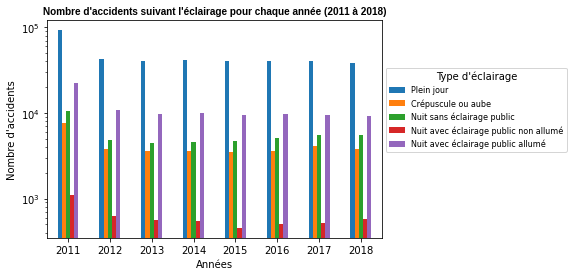

In [21]:
plt.figure(figsize=(15,8))

df_finalannees.plot.bar(logy=True)
lumiere=['Plein jour', 'Crépuscule ou aube', 'Nuit sans éclairage public', 'Nuit avec éclairage public non allumé', 'Nuit avec éclairage public allumé']

# Renommer aux des abscisses
plt.xticks([0, 1, 2,3,4,5,6,7], labels=['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'],rotation=0)
plt.legend(labels = lumiere, title = "Type d'éclairage", bbox_to_anchor=(1,0.8), fontsize=8, loc='upper left')

plt.title("Nombre d'accidents suivant l'éclairage pour chaque année (2011 à 2018)", fontname ="Liberation Sans", fontsize=10, fontweight='bold')
plt.xlabel("Années", fontsize = 10)
plt.ylabel("Nombre d'accidents", fontsize = 10)
plt.show()

### Autre représentation graphique : courbes (Evolution du nombre d'accidents suivant l'éclairage pour chaque année (2011 à 2018))

<Figure size 1080x576 with 0 Axes>

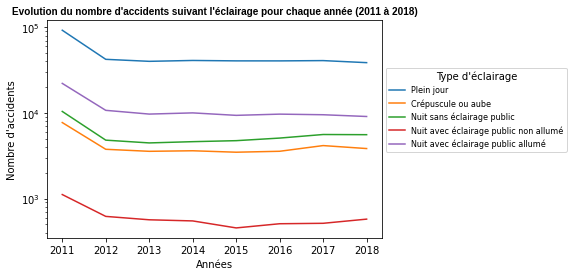

In [22]:
plt.figure(figsize=(15,8))

df_finalannees.plot(logy=True)
lumiere=['Plein jour', 'Crépuscule ou aube', 'Nuit sans éclairage public', 'Nuit avec éclairage public non allumé', 'Nuit avec éclairage public allumé']

# Renommer aux des abscisses
plt.xticks([0, 1, 2,3,4,5,6,7], labels=['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'],rotation=0)
plt.legend(labels = lumiere, title = "Type d'éclairage", bbox_to_anchor=(1,0.8), fontsize=8, loc='upper left')

plt.title("Evolution du nombre d'accidents suivant l'éclairage pour chaque année (2011 à 2018)", 
          fontname ="Liberation Sans", fontsize=10, fontweight='bold')
plt.xlabel("Années", fontsize = 10)
plt.ylabel("Nombre d'accidents", fontsize = 10)
plt.show()

**Observation :**

On observe que le nombre d'accidents pour chaque type d'éclairage semble plutôt constant sur la plage des années (de 2012 à 2018).

On remarque tout de même une nette diminution du nombre d'accidents à partir de l'année 2012 pour tous les niveaux d'éclairage.


## Deuxième partie : Prédiction du nombre d'accidents suivant l'éclairage

On souhaite alors utiliser le machine learning dans le but de prédire le nombre d'accidents pour chaque niveau d'éclairage.

In [25]:
# Affichage des 10 premières valeurs du jeu de données
data2.head(10)

,lum,an,Num_Acc
0,1,11,92538
1,1,12,42322
2,1,13,40098
3,1,14,41049
4,1,15,40598
5,1,16,40578
6,1,17,40895
7,1,18,38701
8,2,11,7726
9,2,12,3764


In [26]:
# Convertir un dataframe Pandas en un spark dataframe
dffinal_spark = spark.createDataFrame(data2)

In [27]:
dffinal_spark.show()

+---+---+-------+
|lum| an|Num_Acc|
+---+---+-------+
|  1| 11|  92538|
|  1| 12|  42322|
|  1| 13|  40098|
|  1| 14|  41049|
|  1| 15|  40598|
|  1| 16|  40578|
|  1| 17|  40895|
|  1| 18|  38701|
|  2| 11|   7726|
|  2| 12|   3764|
|  2| 13|   3564|
|  2| 14|   3617|
|  2| 15|   3479|
|  2| 16|   3568|
|  2| 17|   4158|
|  2| 18|   3839|
|  3| 11|  10416|
|  3| 12|   4813|
|  3| 13|   4467|
|  3| 14|   4620|
+---+---+-------+
only showing top 20 rows



In [28]:
type(dffinal_spark)

pyspark.sql.dataframe.DataFrame

In [29]:
# Modifier le type de variables en entier
dffinal_spark = dffinal_spark.withColumn("lum",col("lum").cast("int"))
dffinal_spark = dffinal_spark.withColumn("an",col("an").cast("int"))

In [30]:
dffinal_spark.cache()
dffinal_spark.printSchema()

root
 |-- lum: integer (nullable = true)
 |-- an: integer (nullable = true)
 |-- Num_Acc: long (nullable = true)



### Dataframes filtrés suivant le niveau d'éclairage 

In [31]:
dataRegLum1 = dffinal_spark.filter(dffinal_spark.lum == "1")
dataRegLum1.show()
dataRegLum2 = dffinal_spark.filter(dffinal_spark.lum == "2")
dataRegLum2.show()
dataRegLum3 = dffinal_spark.filter(dffinal_spark.lum == "3")
dataRegLum3.show()
dataRegLum4 = dffinal_spark.filter(dffinal_spark.lum == "4")
dataRegLum4.show()
dataRegLum5 = dffinal_spark.filter(dffinal_spark.lum == "5")
dataRegLum5.show()

+---+---+-------+
|lum| an|Num_Acc|
+---+---+-------+
|  1| 11|  92538|
|  1| 12|  42322|
|  1| 13|  40098|
|  1| 14|  41049|
|  1| 15|  40598|
|  1| 16|  40578|
|  1| 17|  40895|
|  1| 18|  38701|
+---+---+-------+

+---+---+-------+
|lum| an|Num_Acc|
+---+---+-------+
|  2| 11|   7726|
|  2| 12|   3764|
|  2| 13|   3564|
|  2| 14|   3617|
|  2| 15|   3479|
|  2| 16|   3568|
|  2| 17|   4158|
|  2| 18|   3839|
+---+---+-------+

+---+---+-------+
|lum| an|Num_Acc|
+---+---+-------+
|  3| 11|  10416|
|  3| 12|   4813|
|  3| 13|   4467|
|  3| 14|   4620|
|  3| 15|   4746|
|  3| 16|   5089|
|  3| 17|   5601|
|  3| 18|   5574|
+---+---+-------+

+---+---+-------+
|lum| an|Num_Acc|
+---+---+-------+
|  4| 11|   1114|
|  4| 12|    619|
|  4| 13|    565|
|  4| 14|    548|
|  4| 15|    454|
|  4| 16|    508|
|  4| 17|    514|
|  4| 18|    575|
+---+---+-------+

+---+---+-------+
|lum| an|Num_Acc|
+---+---+-------+
|  5| 11|  22154|
|  5| 12|  10732|
|  5| 13|   9703|
|  5| 14|  10020|
|  5| 

### Combine une liste de colonnes en une seule colonne vectorielle features

In [32]:
vectorAssembler1 = VectorAssembler(inputCols = ['lum'], outputCol = 'features')
datareg1 = vectorAssembler1.transform(dataRegLum1)
dataregFinal1 = datareg1.select(['features', 'Num_Acc'])
dataregFinal1.show()

vectorAssembler2 = VectorAssembler(inputCols = ['lum'], outputCol = 'features')
datareg2 = vectorAssembler2.transform(dataRegLum2)
dataregFinal2 = datareg2.select(['features', 'Num_Acc'])
dataregFinal2.show()

vectorAssembler3 = VectorAssembler(inputCols = ['lum'], outputCol = 'features')
datareg3 = vectorAssembler3.transform(dataRegLum3)
dataregFinal3 = datareg3.select(['features', 'Num_Acc'])
dataregFinal3.show()

vectorAssembler4 = VectorAssembler(inputCols = ['lum'], outputCol = 'features')
datareg4 = vectorAssembler4.transform(dataRegLum4)
dataregFinal4 = datareg4.select(['features', 'Num_Acc'])
dataregFinal4.show()

vectorAssembler5 = VectorAssembler(inputCols = ['lum'], outputCol = 'features')
datareg5 = vectorAssembler5.transform(dataRegLum5)
dataregFinal5 = datareg5.select(['features', 'Num_Acc'])
dataregFinal5.show()

+--------+-------+
|features|Num_Acc|
+--------+-------+
|   [1.0]|  92538|
|   [1.0]|  42322|
|   [1.0]|  40098|
|   [1.0]|  41049|
|   [1.0]|  40598|
|   [1.0]|  40578|
|   [1.0]|  40895|
|   [1.0]|  38701|
+--------+-------+

+--------+-------+
|features|Num_Acc|
+--------+-------+
|   [2.0]|   7726|
|   [2.0]|   3764|
|   [2.0]|   3564|
|   [2.0]|   3617|
|   [2.0]|   3479|
|   [2.0]|   3568|
|   [2.0]|   4158|
|   [2.0]|   3839|
+--------+-------+

+--------+-------+
|features|Num_Acc|
+--------+-------+
|   [3.0]|  10416|
|   [3.0]|   4813|
|   [3.0]|   4467|
|   [3.0]|   4620|
|   [3.0]|   4746|
|   [3.0]|   5089|
|   [3.0]|   5601|
|   [3.0]|   5574|
+--------+-------+

+--------+-------+
|features|Num_Acc|
+--------+-------+
|   [4.0]|   1114|
|   [4.0]|    619|
|   [4.0]|    565|
|   [4.0]|    548|
|   [4.0]|    454|
|   [4.0]|    508|
|   [4.0]|    514|
|   [4.0]|    575|
+--------+-------+

+--------+-------+
|features|Num_Acc|
+--------+-------+
|   [5.0]|  22154|
|   [5.0

### Régression linéaire pour chaque niveau d'éclairage

On estime une droite de régression pour chaque niveau d'éclairage.

#### Première droite

In [33]:
# Préparer les données
splits1 = dataregFinal1.randomSplit([0.7, 0.3])
train_df1 = splits1[0]
test_df1 = splits1[1]

lr1 = LinearRegression(featuresCol = 'features', labelCol='Num_Acc', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model1 = lr1.fit(train_df1)

# Récupère les coefficients du modèle
#print("Coefficients: " + str(lr_model1.coefficients))
print("Intercept : " + str(lr_model1.intercept))

Intercept : 50972.2


#### Deuxième droite

In [34]:
# Préparer les données
splits2 = dataregFinal2.randomSplit([0.7, 0.3])
train_df2 = splits2[0]
test_df2 = splits2[1]

lr2 = LinearRegression(featuresCol = 'features', labelCol='Num_Acc', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model2 = lr2.fit(train_df2)

# Récupère les coefficients du modèle
#print("Coefficients: " + str(lr_model2.coefficients))
print("Intercept: " + str(lr_model2.intercept))

Intercept: 4436.5


#### Troisième droite

In [35]:
# Préparer les données
splits3 = dataregFinal3.randomSplit([0.7, 0.3])
train_df3 = splits3[0]
test_df3 = splits3[1]

lr3 = LinearRegression(featuresCol = 'features', labelCol='Num_Acc', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model3 = lr3.fit(train_df3)

# Récupère les coefficients du modèle
#print("Coefficients: " + str(lr_model3.coefficients))
print("Intercept: " + str(lr_model3.intercept))

Intercept: 4889.333333333333


#### Quatrième droite

In [36]:
# Préparer les données
splits4 = dataregFinal4.randomSplit([0.7, 0.3])
train_df4 = splits4[0]
test_df4 = splits4[1]

lr4 = LinearRegression(featuresCol = 'features', labelCol='Num_Acc', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model4 = lr4.fit(train_df4)

# Récupère les coefficients du modèle
#print("Coefficients: " + str(lr_model4.coefficients))
print("Intercept: " + str(lr_model4.intercept))

Intercept: 519.8


#### Cinquième droite

In [37]:
# Préparer les données
splits5 = dataregFinal5.randomSplit([0.7, 0.3])
train_df5 = splits5[0]
test_df5 = splits5[1]

lr5 = LinearRegression(featuresCol = 'features', labelCol='Num_Acc', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model5 = lr5.fit(train_df5)

# Récupère les coefficients du modèle
#print("Coefficients: " + str(lr_model5.coefficients))
print("Intercept: " + str(lr_model5.intercept))

Intercept: 11287.75


### Affichage des résultats de prédiction

In [38]:
print(f"La prédiction du nombre d'accidents pour lum=1 est {int(lr_model1.intercept)}.")
print(f"La prédiction du nombre d'accidents pour lum=2 est {int(lr_model2.intercept)}.")
print(f"La prédiction du nombre d'accidents pour lum=3 est {int(lr_model3.intercept)}.")
print(f"La prédiction du nombre d'accidents pour lum=4 est {int(lr_model4.intercept)}.")
print(f"La prédiction du nombre d'accidents pour lum=5 est {int(lr_model5.intercept)}.")

La prédiction du nombre d'accidents pour lum=1 est 50972.
La prédiction du nombre d'accidents pour lum=2 est 4436.
La prédiction du nombre d'accidents pour lum=3 est 4889.
La prédiction du nombre d'accidents pour lum=4 est 519.
La prédiction du nombre d'accidents pour lum=5 est 11287.


<Figure size 1080x576 with 0 Axes>

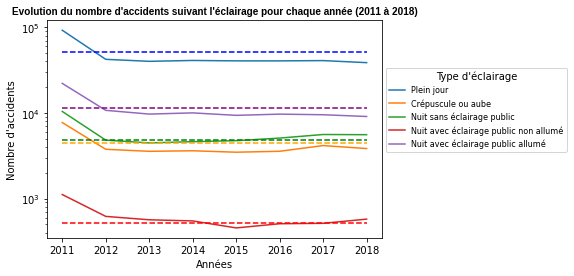

In [39]:
# Tracer des droites de régression superposés aux données observés

plt.figure(figsize=(15,8))

df_finalannees.plot(logy=True)
temps = [0,1,2,3,4,5,6,7]

plt.plot(temps,lr_model1.coefficients*temps+lr_model1.intercept, c='blue', linestyle='--',)
plt.plot(temps,lr_model2.coefficients*temps+lr_model2.intercept, c='orange', linestyle='--',)
plt.plot(temps,lr_model3.coefficients*temps+lr_model3.intercept, c='green', linestyle='--',)
plt.plot(temps,lr_model4.coefficients*temps+lr_model4.intercept, c='red', linestyle='--',)
plt.plot(temps,lr_model5.coefficients*temps+lr_model5.intercept, c='purple', linestyle='--',)

lumiere=['Plein jour', 'Crépuscule ou aube', 'Nuit sans éclairage public', 'Nuit avec éclairage public non allumé', 'Nuit avec éclairage public allumé']

# Renommer aux des abscisses
plt.xticks(temps, labels=['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'],rotation=0)
plt.legend(labels = lumiere, title = "Type d'éclairage", bbox_to_anchor=(1,0.8), fontsize=8, loc='upper left')

plt.title("Evolution du nombre d'accidents suivant l'éclairage pour chaque année (2011 à 2018)", 
          fontname ="Liberation Sans", fontsize=10, fontweight='bold')
plt.xlabel("Années", fontsize = 10)
plt.ylabel("Nombre d'accidents", fontsize = 10)
plt.show()

On observe que le droite estimée par machine learning se rapproche bien des données. En revanche, la prédiction semble moins fiable si on garde l'année 2011.

### Représentation des prédictions en enlevant l'année 2011

In [40]:
# Enlever l'année 2011
dffinal_sparkbis = dffinal_spark.filter(dffinal_spark.an != 11)
dffinal_sparkbis.show()

+---+---+-------+
|lum| an|Num_Acc|
+---+---+-------+
|  1| 12|  42322|
|  1| 13|  40098|
|  1| 14|  41049|
|  1| 15|  40598|
|  1| 16|  40578|
|  1| 17|  40895|
|  1| 18|  38701|
|  2| 12|   3764|
|  2| 13|   3564|
|  2| 14|   3617|
|  2| 15|   3479|
|  2| 16|   3568|
|  2| 17|   4158|
|  2| 18|   3839|
|  3| 12|   4813|
|  3| 13|   4467|
|  3| 14|   4620|
|  3| 15|   4746|
|  3| 16|   5089|
|  3| 17|   5601|
+---+---+-------+
only showing top 20 rows



In [41]:
dataRegLum1bis = dffinal_sparkbis.filter(dffinal_sparkbis.lum == "1")
dataRegLum1bis.show()
dataRegLum2bis = dffinal_sparkbis.filter(dffinal_sparkbis.lum == "2")
dataRegLum2bis.show()
dataRegLum3bis = dffinal_sparkbis.filter(dffinal_sparkbis.lum == "3")
dataRegLum3bis.show()
dataRegLum4bis = dffinal_sparkbis.filter(dffinal_sparkbis.lum == "4")
dataRegLum4bis.show()
dataRegLum5bis = dffinal_sparkbis.filter(dffinal_sparkbis.lum == "5")
dataRegLum5bis.show()

+---+---+-------+
|lum| an|Num_Acc|
+---+---+-------+
|  1| 12|  42322|
|  1| 13|  40098|
|  1| 14|  41049|
|  1| 15|  40598|
|  1| 16|  40578|
|  1| 17|  40895|
|  1| 18|  38701|
+---+---+-------+

+---+---+-------+
|lum| an|Num_Acc|
+---+---+-------+
|  2| 12|   3764|
|  2| 13|   3564|
|  2| 14|   3617|
|  2| 15|   3479|
|  2| 16|   3568|
|  2| 17|   4158|
|  2| 18|   3839|
+---+---+-------+

+---+---+-------+
|lum| an|Num_Acc|
+---+---+-------+
|  3| 12|   4813|
|  3| 13|   4467|
|  3| 14|   4620|
|  3| 15|   4746|
|  3| 16|   5089|
|  3| 17|   5601|
|  3| 18|   5574|
+---+---+-------+

+---+---+-------+
|lum| an|Num_Acc|
+---+---+-------+
|  4| 12|    619|
|  4| 13|    565|
|  4| 14|    548|
|  4| 15|    454|
|  4| 16|    508|
|  4| 17|    514|
|  4| 18|    575|
+---+---+-------+

+---+---+-------+
|lum| an|Num_Acc|
+---+---+-------+
|  5| 12|  10732|
|  5| 13|   9703|
|  5| 14|  10020|
|  5| 15|   9377|
|  5| 16|   9689|
|  5| 17|   9533|
|  5| 18|   9094|
+---+---+-------+



In [42]:
vectorAssembler1bis = VectorAssembler(inputCols = ['lum'], outputCol = 'features')
datareg1bis = vectorAssembler1bis.transform(dataRegLum1bis)
dataregFinal1bis = datareg1bis.select(['features', 'Num_Acc'])
dataregFinal1bis.show()

vectorAssembler2bis = VectorAssembler(inputCols = ['lum'], outputCol = 'features')
datareg2bis = vectorAssembler2bis.transform(dataRegLum2bis)
dataregFinal2bis = datareg2bis.select(['features', 'Num_Acc'])
dataregFinal2bis.show()

vectorAssembler3bis = VectorAssembler(inputCols = ['lum'], outputCol = 'features')
datareg3bis = vectorAssembler3bis.transform(dataRegLum3bis)
dataregFinal3bis = datareg3bis.select(['features', 'Num_Acc'])
dataregFinal3bis.show()

vectorAssembler4bis = VectorAssembler(inputCols = ['lum'], outputCol = 'features')
datareg4bis = vectorAssembler4bis.transform(dataRegLum4bis)
dataregFinal4bis = datareg4bis.select(['features', 'Num_Acc'])
dataregFinal4bis.show()

vectorAssembler5bis = VectorAssembler(inputCols = ['lum'], outputCol = 'features')
datareg5bis = vectorAssembler5bis.transform(dataRegLum5bis)
dataregFinal5bis = datareg5bis.select(['features', 'Num_Acc'])
dataregFinal5bis.show()

+--------+-------+
|features|Num_Acc|
+--------+-------+
|   [1.0]|  42322|
|   [1.0]|  40098|
|   [1.0]|  41049|
|   [1.0]|  40598|
|   [1.0]|  40578|
|   [1.0]|  40895|
|   [1.0]|  38701|
+--------+-------+

+--------+-------+
|features|Num_Acc|
+--------+-------+
|   [2.0]|   3764|
|   [2.0]|   3564|
|   [2.0]|   3617|
|   [2.0]|   3479|
|   [2.0]|   3568|
|   [2.0]|   4158|
|   [2.0]|   3839|
+--------+-------+

+--------+-------+
|features|Num_Acc|
+--------+-------+
|   [3.0]|   4813|
|   [3.0]|   4467|
|   [3.0]|   4620|
|   [3.0]|   4746|
|   [3.0]|   5089|
|   [3.0]|   5601|
|   [3.0]|   5574|
+--------+-------+

+--------+-------+
|features|Num_Acc|
+--------+-------+
|   [4.0]|    619|
|   [4.0]|    565|
|   [4.0]|    548|
|   [4.0]|    454|
|   [4.0]|    508|
|   [4.0]|    514|
|   [4.0]|    575|
+--------+-------+

+--------+-------+
|features|Num_Acc|
+--------+-------+
|   [5.0]|  10732|
|   [5.0]|   9703|
|   [5.0]|  10020|
|   [5.0]|   9377|
|   [5.0]|   9689|
|   [5.0

#### Première droite

In [43]:
# Préparer les données
splits1bis = dataregFinal1bis.randomSplit([0.7, 0.3])
train_df1bis = splits1bis[0]
test_df1bis = splits1bis[1]

lr1bis = LinearRegression(featuresCol = 'features', labelCol='Num_Acc', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model1bis = lr1bis.fit(train_df1bis)

# Récupère les coefficients du modèle
#print("Coefficients: " + str(lr_model1bis.coefficients))
print("Intercept : " + str(lr_model1bis.intercept))

Intercept : 40992.4


#### Deuxième droite

In [44]:
# Préparer les données
splits2bis = dataregFinal2bis.randomSplit([0.7, 0.3])
train_df2bis = splits2bis[0]
test_df2bis = splits2bis[1]

lr2bis = LinearRegression(featuresCol = 'features', labelCol='Num_Acc', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model2bis = lr2bis.fit(train_df2bis)

# Récupère les coefficients du modèle
#print("Coefficients: " + str(lr_model2bis.coefficients))
print("Intercept: " + str(lr_model2bis.intercept))

Intercept: 3674.75


#### Troisième droite

In [45]:
# Préparer les données
splits3bis = dataregFinal3bis.randomSplit([0.7, 0.3])
train_df3bis = splits3bis[0]
test_df3bis = splits3bis[1]

lr3bis = LinearRegression(featuresCol = 'features', labelCol='Num_Acc', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model3bis = lr3bis.fit(train_df3bis)

# Récupère les coefficients du modèle
#print("Coefficients: " + str(lr_model3bis.coefficients))
print("Intercept: " + str(lr_model3bis.intercept))

Intercept: 4937.8


#### Quatrième droite

In [46]:
# Préparer les données
splits4bis = dataregFinal4bis.randomSplit([0.7, 0.3])
train_df4bis = splits4bis[0]
test_df4bis = splits4bis[1]

lr4bis = LinearRegression(featuresCol = 'features', labelCol='Num_Acc', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model4bis = lr4bis.fit(train_df4bis)

# Récupère les coefficients du modèle
#print("Coefficients: " + str(lr_model4bis.coefficients))
print("Intercept: " + str(lr_model4bis.intercept))

Intercept: 532.0


#### Cinquième droite

In [47]:
# Préparer les données
splits5bis = dataregFinal5bis.randomSplit([0.7, 0.3])
train_df5bis = splits5bis[0]
test_df5bis = splits5bis[1]

lr5bis = LinearRegression(featuresCol = 'features', labelCol='Num_Acc', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model5bis = lr5bis.fit(train_df5bis)

# Récupère les coefficients du modèle
#print("Coefficients: " + str(lr_model5bis.coefficients))
print("Intercept: " + str(lr_model5bis.intercept))

Intercept: 9658.25


### Affichage des résultats de prédiction

In [48]:
print(f"La prédiction du nombre d'accidents pour lum=1 est {int(lr_model1bis.intercept)}.")
print(f"La prédiction du nombre d'accidents pour lum=2 est {int(lr_model2bis.intercept)}.")
print(f"La prédiction du nombre d'accidents pour lum=3 est {int(lr_model3bis.intercept)}.")
print(f"La prédiction du nombre d'accidents pour lum=4 est {int(lr_model4bis.intercept)}.")
print(f"La prédiction du nombre d'accidents pour lum=5 est {int(lr_model5bis.intercept)}.")

La prédiction du nombre d'accidents pour lum=1 est 40992.
La prédiction du nombre d'accidents pour lum=2 est 3674.
La prédiction du nombre d'accidents pour lum=3 est 4937.
La prédiction du nombre d'accidents pour lum=4 est 532.
La prédiction du nombre d'accidents pour lum=5 est 9658.


### Représenttation finales des données et des droites de régression prédites

<Figure size 1440x720 with 0 Axes>

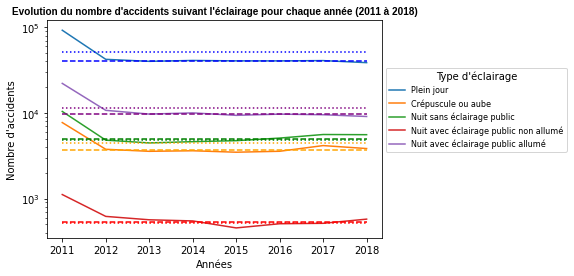

In [49]:
# Tracer des droites de régression des 2 modèles (avec et sans année 2011) superposés aux données observés

plt.figure(figsize=(20,10))

temps = [0,1,2,3,4,5,6,7]

# Evolution du nombre d'accidents par année
df_finalannees.plot(logy=True)

# Prédictions de 2011 à 2018 (pointillés)
plt.plot(temps,lr_model1.coefficients*temps+lr_model1.intercept, c='blue', linestyle='dotted',)
plt.plot(temps,lr_model2.coefficients*temps+lr_model2.intercept, c='orange', linestyle='dotted',)
plt.plot(temps,lr_model3.coefficients*temps+lr_model3.intercept, c='green', linestyle='dotted',)
plt.plot(temps,lr_model4.coefficients*temps+lr_model4.intercept, c='red', linestyle='dotted',)
plt.plot(temps,lr_model5.coefficients*temps+lr_model5.intercept, c='purple', linestyle='dotted',)

# Prédictions nouvelles en considérant de 2012 à 2018 (tirets)
plt.plot(temps,lr_model1bis.coefficients*temps+lr_model1bis.intercept, c='blue', linestyle='--',)
plt.plot(temps,lr_model2bis.coefficients*temps+lr_model2bis.intercept, c='orange', linestyle='--',)
plt.plot(temps,lr_model3bis.coefficients*temps+lr_model3bis.intercept, c='green', linestyle='--',)
plt.plot(temps,lr_model4bis.coefficients*temps+lr_model4bis.intercept, c='red', linestyle='--',)
plt.plot(temps,lr_model5bis.coefficients*temps+lr_model5bis.intercept, c='purple', linestyle='--',)

lumiere=['Plein jour', 'Crépuscule ou aube', 'Nuit sans éclairage public', 'Nuit avec éclairage public non allumé', 'Nuit avec éclairage public allumé']

# Renommer aux des abscisses
plt.xticks(temps, labels=['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'],rotation=0)
plt.legend(labels = lumiere, title = "Type d'éclairage", bbox_to_anchor=(1,0.8), fontsize=8, loc='upper left')

plt.title("Evolution du nombre d'accidents suivant l'éclairage pour chaque année (2011 à 2018)", 
          fontname ="Liberation Sans", fontsize=10, fontweight='bold')
plt.xlabel("Années", fontsize = 10)
plt.ylabel("Nombre d'accidents", fontsize = 10)
plt.show()

In [54]:
temps = [2011,2012,2013,2014,2015,2016,2017,2018]
lumiere=['Plein jour', 'Crépuscule ou aube', 'Nuit sans éclairage public', 'Nuit avec éclairage public non allumé', 'Nuit avec éclairage public allumé']

fig = go.Figure()

# Evolution du Nombre d'accidents suivant l'année
fig.add_trace(go.Scatter(x = temps, y = data3.iloc[0,:], mode='lines', name=lumiere[0], marker_color="blue"))
fig.add_trace(go.Scatter(x = temps, y = data3.iloc[1,:], mode='lines', name=lumiere[1], marker_color="orange"))
fig.add_trace(go.Scatter(x = temps, y = data3.iloc[2,:], mode='lines', name=lumiere[2], marker_color="green"))
fig.add_trace(go.Scatter(x = temps, y = data3.iloc[3,:], mode='lines', name=lumiere[3], marker_color="red"))
fig.add_trace(go.Scatter(x = temps, y = data3.iloc[4,:], mode='lines', name=lumiere[4], marker_color="purple"))

# Prédictions de 2011 à 2018
fig.add_trace(go.Scatter(x = temps, y = lr_model1.coefficients*temps+lr_model1.intercept, 
                         line = dict(color='blue', width=4, dash='dot'), name='Prédiction de '+lumiere[0]))
fig.add_trace(go.Scatter(x = temps, y = lr_model2.coefficients*temps+lr_model2.intercept, 
                         line = dict(color='orange', width=4, dash='dot'), name='Prédiction de '+lumiere[1]))
fig.add_trace(go.Scatter(x = temps, y = lr_model3.coefficients*temps+lr_model3.intercept, 
                         line = dict(color='green', width=4, dash='dot'), name='Prédiction de '+lumiere[2]))
fig.add_trace(go.Scatter(x = temps, y = lr_model4.coefficients*temps+lr_model4.intercept, 
                         line = dict(color='red', width=4, dash='dot'), name='Prédiction de '+lumiere[3]))
fig.add_trace(go.Scatter(x = temps, y = lr_model5.coefficients*temps+lr_model5.intercept, 
                         line = dict(color='purple', width=4, dash='dot'), name='Prédiction de '+lumiere[4]))

# Prédictions nouvelles en considérant de 2012 à 2018 (tirets)
fig.add_trace(go.Scatter(x = temps, y = lr_model1bis.coefficients*temps+lr_model1bis.intercept, 
                         line = dict(color='blue', width=1, dash='dash'), name='Nouvelle Prédiction de '+lumiere[0]))
fig.add_trace(go.Scatter(x = temps, y = lr_model2bis.coefficients*temps+lr_model2bis.intercept, 
                         line = dict(color='orange', width=1, dash='dash'), name='Nouvelle Prédiction de '+lumiere[1]))
fig.add_trace(go.Scatter(x = temps, y = lr_model3bis.coefficients*temps+lr_model3bis.intercept, 
                         line = dict(color='green', width=1, dash='dash'), name='Nouvelle Prédiction de '+lumiere[2]))
fig.add_trace(go.Scatter(x = temps, y = lr_model4bis.coefficients*temps+lr_model4bis.intercept, 
                         line = dict(color='red', width=1, dash='dash'), name='Nouvelle Prédiction de '+lumiere[3]))
fig.add_trace(go.Scatter(x = temps, y = lr_model5bis.coefficients*temps+lr_model5bis.intercept, 
                         line = dict(color='purple', width=1, dash='dash'), name='Nouvelle Prédiction de '+lumiere[4]))


# Paramètres de la fenêtre graphique et des axes
fig.update_layout(
    title_text="Evolution du nombre d'accidents suivant l'éclairage pour chaque année (2011 à 2018)",
    margin=dict(l=50, r=20, t=60, b=10), # marges du graphique
    paper_bgcolor="#f2f5f9",             # couleur de fond
    width=1000,                          # largeur du graphique
    height=600,                          # hauteur du graphique

    yaxis=dict(
        title_text="Nombre d'accidents",
        titlefont=dict(size=15),
    ),
    xaxis=dict(
        title_text="Années",
        titlefont=dict(size=15),
    )
)
fig.show()

On observe que les droites estimées par machine learning se rapproche beaucoup mieux des données. 

A l'aide de ce graphique interactifs, ceci est nettement visible lorsque l'on zoome le graphique sur les droites en bleu et en violet (Plein Jour & Nuit avec éclairage public).